# Fase 4: Entrenamiento y Selecci√≥n de Modelos de Clasificaci√≥n

## Objetivo del Notebook

Este notebook constituye la cuarta fase del pipeline de mantenimiento predictivo para sistemas de moto-compresores. El objetivo principal es entrenar, evaluar y seleccionar un modelo de clasificaci√≥n binaria capaz de predecir si ocurrir√° una falla en los pr√≥ximos 7 d√≠as, utilizando las caracter√≠sticas derivadas del proceso de ingenier√≠a de caracter√≠sticas implementado en la fase anterior.

### Metodolog√≠a de Entrenamiento

La metodolog√≠a implementada se basa en principios fundamentales de machine learning para series temporales, priorizando:

1. **Divisi√≥n Cronol√≥gica de Datos**: Implementaci√≥n de una divisi√≥n temporal que respete la naturaleza secuencial de los datos operacionales, evitando la fuga de informaci√≥n (data leakage) que comprometer√≠a la validez del modelo.

2. **Manejo de Desbalance de Clases**: Aplicaci√≥n de t√©cnicas espec√≠ficas para abordar la distribuci√≥n desigual entre muestras de operaci√≥n normal y muestras pre-falla, fundamental en aplicaciones de mantenimiento predictivo.

3. **Evaluaci√≥n Robusta**: Utilizaci√≥n de m√©tricas de rendimiento apropiadas para clasificaci√≥n desbalanceada, que proporcionen una evaluaci√≥n objetiva de la capacidad predictiva del modelo.

4. **Simplicidad Computacional**: Selecci√≥n de algoritmos que mantengan un balance √≥ptimo entre rendimiento predictivo y eficiencia computacional.

### Variable Objetivo Creada

La variable objetivo 'falla' ha sido creada bas√°ndose en el historial real de eventos de falla del compresor, donde:
- **Clase 0 (Normal)**: Operaci√≥n normal del equipo
- **Clase 1 (Pre-falla)**: Muestras dentro de la ventana de 7 d√≠as previa a una falla documentada

### Librer√≠as y Dependencias

El desarrollo requiere las siguientes librer√≠as especializadas:
- **pandas, numpy**: Manipulaci√≥n y procesamiento de datos
- **pathlib**: Gesti√≥n de rutas del sistema de archivos
- **joblib**: Serializaci√≥n eficiente de modelos
- **matplotlib, seaborn**: Visualizaci√≥n de resultados y m√©tricas
- **sklearn**: Algoritmos de machine learning, pipelines y m√©tricas de evaluaci√≥n

In [10]:
# Importaci√≥n de librer√≠as fundamentales para manipulaci√≥n de datos
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Librer√≠as para visualizaci√≥n de resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraci√≥n de estilo para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Importaci√≥n de algoritmos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Importaci√≥n de herramientas de pipeline y preprocesamiento
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # ‚úÖ AGREGADO: Para manejo de valores NaN
from sklearn.model_selection import train_test_split

# Importaci√≥n de m√©tricas de evaluaci√≥n para clasificaci√≥n
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score
)

# Definici√≥n de rutas del proyecto
data_processed_path = Path('./data/processed')
models_path = Path('./data/models')

# Creaci√≥n de directorio de modelos si no existe
models_path.mkdir(exist_ok=True)

print("Configuraci√≥n del entorno completada exitosamente")
print(f"Directorio de datos procesados: {data_processed_path}")
print(f"Directorio de modelos: {models_path}")
print("‚úÖ SimpleImputer agregado para manejo de valores NaN")

Configuraci√≥n del entorno completada exitosamente
Directorio de datos procesados: data/processed
Directorio de modelos: data/models
‚úÖ SimpleImputer agregado para manejo de valores NaN


## Paso 2: Carga y Preparaci√≥n de Datos

### Proceso de Carga de Dataset

En esta etapa se procede a cargar el dataset resultante del proceso de ingenier√≠a de caracter√≠sticas desarrollado en la fase anterior, ahora enriquecido con la variable objetivo 'falla' creada a partir del historial real de eventos de mantenimiento. El archivo se buscar√° primero como `featured_dataset_for_modeling.parquet` y si no se encuentra con variable objetivo, se buscar√° `featured_dataset_with_target.parquet`.

El dataset contiene:

- **Caracter√≠sticas originales de sensores**: Variables operacionales directas del moto-compresor
- **Caracter√≠sticas de ventanas m√≥viles**: Estad√≠sticos calculados sobre per√≠odos temporales espec√≠ficos
- **Caracter√≠sticas de lag temporal**: Variables retardadas que capturan dependencias temporales
- **Variable objetivo**: Indicador binario de proximidad a falla basado en eventos reales documentados

### Creaci√≥n Autom√°tica de Variable Objetivo

Si la variable objetivo no existe, se ejecutar√° autom√°ticamente el proceso de creaci√≥n utilizando el historial de eventos de falla documentados. El proceso implementa:

1. **Extracci√≥n de Fechas**: Procesamiento autom√°tico de todas las fechas de eventos del historial
2. **Ventana de Pre-falla**: Definici√≥n de una ventana de 7 d√≠as previos a cada evento como per√≠odo cr√≠tico
3. **Etiquetado**: Las muestras dentro de estas ventanas se etiquetan como 'pre-falla' (1), el resto como 'normal' (0)

### Separaci√≥n de Caracter√≠sticas y Variable Objetivo

La preparaci√≥n de datos requiere la separaci√≥n clara entre la matriz de caracter√≠sticas (X) y el vector de variable objetivo (y) para el entrenamiento supervisado del modelo de clasificaci√≥n.

In [11]:
# Carga del dataset con caracter√≠sticas de ingenier√≠a y variable objetivo

# Intentar cargar primero el dataset con variable objetivo
dataset_with_target_path = data_processed_path / 'featured_dataset_with_target.parquet'
dataset_original_path = data_processed_path / 'featured_dataset_for_modeling.parquet'

if dataset_with_target_path.exists():
    dataset_path = dataset_with_target_path
    print(f"Cargando dataset con variable objetivo desde: {dataset_path}")
else:
    dataset_path = dataset_original_path
    print(f"Cargando dataset original desde: {dataset_path}")

try:
    df = pd.read_parquet(dataset_path)
    print(f"Dataset cargado exitosamente")
    print(f"Dimensiones del dataset: {df.shape}")
    print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Verificar si existe la variable objetivo
    if 'falla' not in df.columns:
        print("\n‚ö†Ô∏è Variable objetivo 'falla' no encontrada")
        print("Ejecutando creaci√≥n autom√°tica de variable objetivo...")
        
        # Ejecutar script para crear variable objetivo
        import subprocess
        result = subprocess.run(['python', 'crear_variable_objetivo.py'], 
                              capture_output=True, text=True, cwd='.')
        print(result.stdout)
        if result.stderr:
            print(f"Errores: {result.stderr}")
        
        # Cargar el dataset actualizado
        df = pd.read_parquet(data_processed_path / 'featured_dataset_with_target.parquet')
        print(f"\n‚úÖ Dataset actualizado cargado: {df.shape}")
        
except FileNotFoundError:
    print(f"Error: No se encontr√≥ el archivo {dataset_path}")
    print("Aseg√∫rese de haber ejecutado el notebook 03_feature_engineering.ipynb")
    raise

# Verificaci√≥n de la estructura del dataset
print("\n=== Informaci√≥n General del Dataset ===")
print(f"Columnas: {len(df.columns)}")
print(f"Filas: {len(df)}")

# An√°lisis de la variable objetivo
print("\n=== Distribuci√≥n de la Variable Objetivo 'falla' ===")
target_distribution = df['falla'].value_counts().sort_index()
print(target_distribution)
print(f"\nPorcentaje de muestras normales (0): {(target_distribution[0] / len(df) * 100):.2f}%")
print(f"Porcentaje de muestras pre-falla (1): {(target_distribution[1] / len(df) * 100):.2f}%")
print(f"Ratio de desbalance: {target_distribution[0] / target_distribution[1]:.1f}:1")

# Separaci√≥n de caracter√≠sticas y variable objetivo
print("\n=== Preparaci√≥n de Matrices de Entrenamiento ===")

# Definici√≥n de la matriz de caracter√≠sticas (X)
# Excluimos la columna 'falla' ya que es nuestra variable objetivo
feature_columns = [col for col in df.columns if col != 'falla']
X = df[feature_columns].copy()

# Definici√≥n del vector objetivo (y)
y = df['falla'].copy()

print(f"Matriz de caracter√≠sticas (X): {X.shape}")
print(f"Vector objetivo (y): {y.shape}")
print(f"N√∫mero de caracter√≠sticas disponibles: {len(feature_columns)}")

# Verificaci√≥n de valores faltantes en caracter√≠sticas
missing_values = X.isnull().sum().sum()
print(f"Valores faltantes en caracter√≠sticas: {missing_values}")

if missing_values > 0:
    print("\nCaracter√≠sticas con valores faltantes:")
    missing_by_column = X.isnull().sum()
    print(missing_by_column[missing_by_column > 0])

print("\n‚úÖ Carga y preparaci√≥n de datos completada")

Cargando dataset con variable objetivo desde: data/processed/featured_dataset_with_target.parquet
Dataset cargado exitosamente
Dimensiones del dataset: (19752, 145)
Memoria utilizada: 11.15 MB

=== Informaci√≥n General del Dataset ===
Columnas: 145
Filas: 19752

=== Distribuci√≥n de la Variable Objetivo 'falla' ===
falla
0    11833
1     7919
Name: count, dtype: int64

Porcentaje de muestras normales (0): 59.91%
Porcentaje de muestras pre-falla (1): 40.09%
Ratio de desbalance: 1.5:1

=== Preparaci√≥n de Matrices de Entrenamiento ===
Matriz de caracter√≠sticas (X): (19752, 144)
Vector objetivo (y): (19752,)
N√∫mero de caracter√≠sticas disponibles: 144
Valores faltantes en caracter√≠sticas: 822

Caracter√≠sticas con valores faltantes:
rpm_roll_6H_std                       1
presion_succion_roll_6H_std           1
presion_intermedia_roll_6H_std        1
presion_descarga_roll_6H_std          1
pres_aceite_comp_roll_6H_std          1
temp_cilindro_1_roll_6H_std           1
temp_cilindro_2_r

## Paso 3: Divisi√≥n Cronol√≥gica de Datos (Time-Based Split)

### Importancia Cr√≠tica de la Divisi√≥n Temporal

La divisi√≥n de datos en series temporales requiere un enfoque metodol√≥gicamente diferente al utilizado en problemas de clasificaci√≥n est√°ndar. La funci√≥n `train_test_split` de scikit-learn con `shuffle=True` es **fundamentalmente incorrecta** para datos de series temporales por las siguientes razones:

#### Problemas de la Divisi√≥n Aleatoria:

1. **Fuga de Informaci√≥n (Data Leakage)**: Una divisi√≥n aleatoria permite que el modelo acceda a informaci√≥n futura durante el entrenamiento, creando una ventaja artificial que no existir√≠a en un escenario de predicci√≥n real.

2. **Validaci√≥n No Realista**: En aplicaciones industriales de mantenimiento predictivo, el modelo debe predecir eventos futuros bas√°ndose √∫nicamente en datos hist√≥ricos. Una divisi√≥n aleatoria no simula esta condici√≥n operacional.

3. **Sobreestimaci√≥n del Rendimiento**: Los resultados obtenidos con divisi√≥n aleatoria tienden a sobrestimar significativamente la capacidad predictiva real del modelo.

#### Metodolog√≠a de Divisi√≥n Cronol√≥gica:

La divisi√≥n cronol√≥gica implementada respeta la naturaleza secuencial de los datos operacionales, utilizando un punto de corte temporal que separa:

- **Conjunto de Entrenamiento**: Datos hist√≥ricos (80% inicial del dataset)
- **Conjunto de Prueba**: Datos m√°s recientes (20% final del dataset)

Esta metodolog√≠a simula fielmente el escenario operacional donde el modelo predice fallas futuras bas√°ndose √∫nicamente en el historial de operaci√≥n disponible hasta el momento de la predicci√≥n.

=== Implementaci√≥n de Divisi√≥n Cronol√≥gica ===
Tama√±o total del dataset: 19752 muestras
Punto de corte temporal: √≠ndice 15801
Proporci√≥n de entrenamiento: 80.0%
Proporci√≥n de prueba: 19.999999999999996%

=== Dimensiones de los Conjuntos Resultantes ===
X_train: (15801, 144)
X_test: (3951, 144)
y_train: (15801,)
y_test: (3951,)

=== Distribuci√≥n de Clases por Conjunto ===
Conjunto de Entrenamiento:
  Clase 0 (normal): 8051 (50.95%)
  Clase 1 (pre-falla): 7750 (49.05%)
  Ratio de desbalance: 1.0:1

Conjunto de Prueba:
  Clase 0 (normal): 3782 (95.72%)
  Clase 1 (pre-falla): 169 (4.28%)
  Ratio de desbalance: 22.4:1


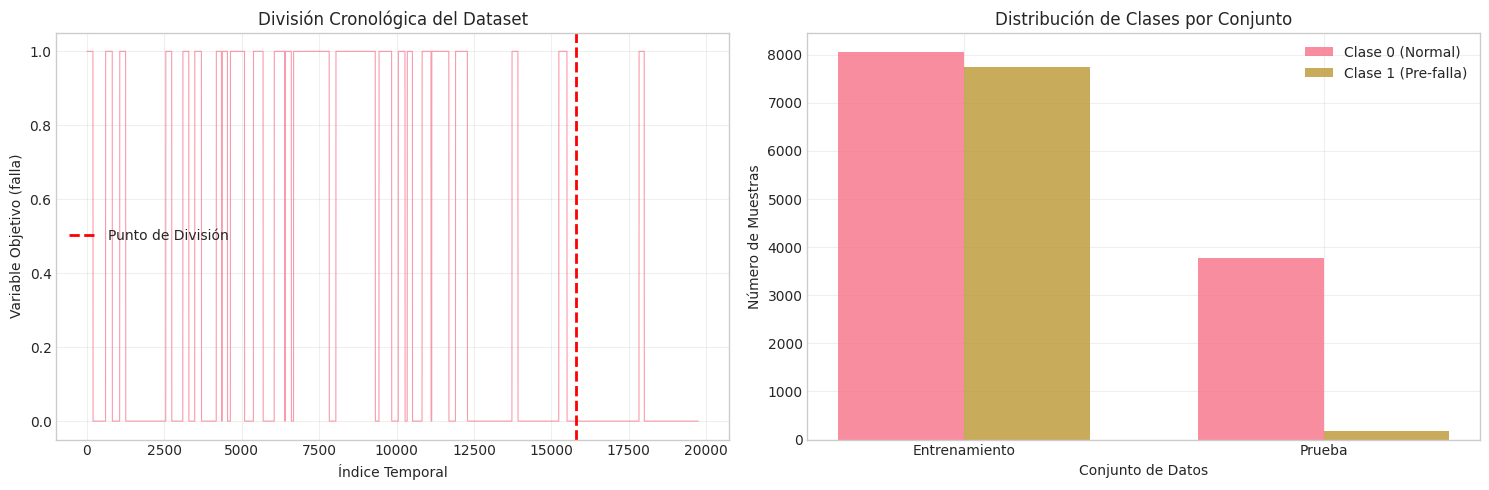


‚úÖ Divisi√≥n cronol√≥gica implementada correctamente
El modelo ser√° entrenado exclusivamente con datos hist√≥ricos
La evaluaci√≥n se realizar√° sobre datos temporalmente posteriores


In [12]:
# Implementaci√≥n de divisi√≥n cronol√≥gica de datos

print("=== Implementaci√≥n de Divisi√≥n Cronol√≥gica ===")

# Definici√≥n del punto de corte temporal (80% para entrenamiento)
train_size = 0.8
split_index = int(len(df) * train_size)

print(f"Tama√±o total del dataset: {len(df)} muestras")
print(f"Punto de corte temporal: √≠ndice {split_index}")
print(f"Proporci√≥n de entrenamiento: {train_size*100}%")
print(f"Proporci√≥n de prueba: {(1-train_size)*100}%")

# Divisi√≥n cronol√≥gica de caracter√≠sticas
X_train = X.iloc[:split_index].copy()
X_test = X.iloc[split_index:].copy()

# Divisi√≥n cronol√≥gica de variable objetivo
y_train = y.iloc[:split_index].copy()
y_test = y.iloc[split_index:].copy()

print(f"\n=== Dimensiones de los Conjuntos Resultantes ===")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# An√°lisis de distribuci√≥n de clases en cada conjunto
print(f"\n=== Distribuci√≥n de Clases por Conjunto ===")

train_distribution = y_train.value_counts().sort_index()
test_distribution = y_test.value_counts().sort_index()

print("Conjunto de Entrenamiento:")
print(f"  Clase 0 (normal): {train_distribution[0]} ({train_distribution[0]/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (pre-falla): {train_distribution[1]} ({train_distribution[1]/len(y_train)*100:.2f}%)")
print(f"  Ratio de desbalance: {train_distribution[0]/train_distribution[1]:.1f}:1")

print("\nConjunto de Prueba:")
print(f"  Clase 0 (normal): {test_distribution[0]} ({test_distribution[0]/len(y_test)*100:.2f}%)")
print(f"  Clase 1 (pre-falla): {test_distribution[1]} ({test_distribution[1]/len(y_test)*100:.2f}%)")
print(f"  Ratio de desbalance: {test_distribution[0]/test_distribution[1]:.1f}:1")

# Visualizaci√≥n de la divisi√≥n cronol√≥gica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribuci√≥n temporal de la variable objetivo
ax1.plot(range(len(y)), y.values, alpha=0.7, linewidth=0.8)
ax1.axvline(x=split_index, color='red', linestyle='--', linewidth=2, label='Punto de Divisi√≥n')
ax1.set_title('Divisi√≥n Cronol√≥gica del Dataset')
ax1.set_xlabel('√çndice Temporal')
ax1.set_ylabel('Variable Objetivo (falla)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Comparaci√≥n de distribuciones de clases
sets = ['Entrenamiento', 'Prueba']
normal_counts = [train_distribution[0], test_distribution[0]]
failure_counts = [train_distribution[1], test_distribution[1]]

x = np.arange(len(sets))
width = 0.35

ax2.bar(x - width/2, normal_counts, width, label='Clase 0 (Normal)', alpha=0.8)
ax2.bar(x + width/2, failure_counts, width, label='Clase 1 (Pre-falla)', alpha=0.8)
ax2.set_title('Distribuci√≥n de Clases por Conjunto')
ax2.set_xlabel('Conjunto de Datos')
ax2.set_ylabel('N√∫mero de Muestras')
ax2.set_xticks(x)
ax2.set_xticklabels(sets)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n‚úÖ Divisi√≥n cronol√≥gica implementada correctamente")
print("El modelo ser√° entrenado exclusivamente con datos hist√≥ricos")
print("La evaluaci√≥n se realizar√° sobre datos temporalmente posteriores")

## Paso 4: Creaci√≥n del Pipeline de Modelado con Manejo de Valores NaN

### Arquitectura de Pipeline para Machine Learning

La implementaci√≥n de un Pipeline de scikit-learn proporciona una arquitectura robusta y escalable para el proceso de modelado, encapsulando tanto el preprocesamiento como el algoritmo de clasificaci√≥n en una unidad cohesiva. Esta aproximaci√≥n ofrece m√∫ltiples ventajas operacionales:

#### Beneficios del Pipeline:

1. **Consistencia en el Preprocesamiento**: Garantiza que las mismas transformaciones aplicadas durante el entrenamiento se apliquen autom√°ticamente durante la inferencia, eliminando discrepancias que podr√≠an degradar el rendimiento del modelo.

2. **Prevenci√≥n de Data Leakage**: El pipeline asegura que las estad√≠sticas de normalizaci√≥n (media, desviaci√≥n est√°ndar) se calculen exclusivamente sobre el conjunto de entrenamiento y se apliquen posteriormente al conjunto de prueba.

3. **Reproducibilidad**: Encapsula todo el proceso de transformaci√≥n y modelado en un objeto serializable, facilitando la reproducibilidad y el despliegue.

4. **Mantenibilidad**: Simplifica el c√≥digo y reduce la posibilidad de errores al manejar m√∫ltiples pasos de procesamiento.

### Componentes del Pipeline ACTUALIZADO:

1. **SimpleImputer**: **NUEVO** - Maneja valores NaN resultantes de caracter√≠sticas de lag y rolling features utilizando la mediana (robusto para datos industriales con outliers)

2. **StandardScaler**: Normaliza las caracter√≠sticas para que tengan media cero y desviaci√≥n est√°ndar uno, requisito fundamental para algoritmos sensibles a la escala como la Regresi√≥n Log√≠stica.

3. **Clasificador**: Algoritmo de machine learning que ser√° intercambiable para permitir la comparaci√≥n de diferentes enfoques.

### ‚úÖ Soluci√≥n Implementada para Valores NaN

Los valores NaN detectados en el dataset son resultado natural de:
- **Lag features**: NaN en las primeras filas por dise√±o (ej: lag_48H crea 48 NaN iniciales)
- **Rolling features**: NaN donde no hay suficientes observaciones para la ventana
- **Diff features**: NaN en diferencias temporales iniciales

**Estrategia adoptada**: Imputaci√≥n con mediana en el pipeline, aplicada antes de la normalizaci√≥n.

In [13]:
# Creaci√≥n del pipeline de modelado con manejo de valores NaN

print("=== Configuraci√≥n del Pipeline de Modelado ACTUALIZADO ===")

def create_pipeline(classifier):
    """
    Crea un pipeline de machine learning con preprocesamiento completo y clasificaci√≥n.
    
    ACTUALIZACI√ìN: Incluye manejo de valores NaN con SimpleImputer
    
    Args:
        classifier: Algoritmo de clasificaci√≥n de scikit-learn
        
    Returns:
        Pipeline configurado con SimpleImputer, StandardScaler y el clasificador especificado
    """
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # ‚úÖ NUEVO: Imputaci√≥n de valores NaN
        ('scaler', StandardScaler()),                   # Normalizaci√≥n de caracter√≠sticas  
        ('classifier', classifier)                      # Algoritmo de clasificaci√≥n
    ])
    return pipeline

# Verificaci√≥n de la estructura de caracter√≠sticas
print(f"N√∫mero de caracter√≠sticas de entrada: {X_train.shape[1]}")
print(f"Tipos de datos en caracter√≠sticas:")
print(X_train.dtypes.value_counts())

# ‚úÖ NUEVO: Verificaci√≥n espec√≠fica de valores NaN
print(f"\n=== An√°lisis de Valores NaN ANTES del Pipeline ===")
nan_count_train = X_train.isnull().sum().sum()
nan_count_test = X_test.isnull().sum().sum()
print(f"Valores NaN en conjunto de entrenamiento: {nan_count_train}")
print(f"Valores NaN en conjunto de prueba: {nan_count_test}")
print(f"Porcentaje de NaN en entrenamiento: {(nan_count_train / (X_train.shape[0] * X_train.shape[1])) * 100:.2f}%")

if nan_count_train > 0:
    print(f"‚úÖ SimpleImputer manejar√° estos valores NaN autom√°ticamente con estrategia 'median'")
    print(f"üìä La mediana es robusta ante outliers, ideal para datos industriales")
else:
    print("‚ÑπÔ∏è No se detectaron valores NaN, pero SimpleImputer permanece como medida preventiva")

# An√°lisis estad√≠stico b√°sico de las caracter√≠sticas
print(f"\n=== Estad√≠sticos de las Caracter√≠sticas (Conjunto de Entrenamiento) ===")
stats_summary = X_train.describe()
print(f"Rango de medias: {stats_summary.loc['mean'].min():.4f} a {stats_summary.loc['mean'].max():.4f}")
print(f"Rango de desviaciones est√°ndar: {stats_summary.loc['std'].min():.4f} a {stats_summary.loc['std'].max():.4f}")
print(f"Rango de valores m√≠nimos: {stats_summary.loc['min'].min():.4f} a {stats_summary.loc['min'].max():.4f}")
print(f"Rango de valores m√°ximos: {stats_summary.loc['max'].min():.4f} a {stats_summary.loc['max'].max():.4f}")

# Demostraci√≥n de la necesidad de normalizaci√≥n
scales_differ = (stats_summary.loc['std'].max() / stats_summary.loc['std'].min()) > 10
print(f"\n¬øLas caracter√≠sticas tienen escalas significativamente diferentes? {scales_differ}")
print(f"Ratio de escala m√°xima/m√≠nima: {stats_summary.loc['std'].max() / stats_summary.loc['std'].min():.1f}")

if scales_differ:
    print("‚úÖ La normalizaci√≥n es necesaria debido a las diferencias de escala entre caracter√≠sticas")
else:
    print("‚ÑπÔ∏è Las caracter√≠sticas tienen escalas similares, pero la normalizaci√≥n sigue siendo recomendable")

print("\n‚úÖ Pipeline de modelado ACTUALIZADO configurado exitosamente")
print("Nueva estructura: SimpleImputer ‚Üí StandardScaler ‚Üí Clasificador")
print("üéØ El pipeline ahora maneja autom√°ticamente los valores NaN de lag/rolling features")

=== Configuraci√≥n del Pipeline de Modelado ACTUALIZADO ===
N√∫mero de caracter√≠sticas de entrada: 144
Tipos de datos en caracter√≠sticas:
float32    144
Name: count, dtype: int64

=== An√°lisis de Valores NaN ANTES del Pipeline ===
Valores NaN en conjunto de entrenamiento: 822
Valores NaN en conjunto de prueba: 0
Porcentaje de NaN en entrenamiento: 0.04%
‚úÖ SimpleImputer manejar√° estos valores NaN autom√°ticamente con estrategia 'median'
üìä La mediana es robusta ante outliers, ideal para datos industriales

=== Estad√≠sticos de las Caracter√≠sticas (Conjunto de Entrenamiento) ===
Rango de medias: -0.6315 a 6839.6802
Rango de desviaciones est√°ndar: 0.0700 a 117722.2656
Rango de valores m√≠nimos: -106808.6875 a 82.1636
Rango de valores m√°ximos: 0.6157 a 8787104.0000

¬øLas caracter√≠sticas tienen escalas significativamente diferentes? True
Ratio de escala m√°xima/m√≠nima: 1681534.7
‚úÖ La normalizaci√≥n es necesaria debido a las diferencias de escala entre caracter√≠sticas

‚úÖ P

## Paso 5: Entrenamiento y Evaluaci√≥n de Modelos Base

### Estrategia de Selecci√≥n de Algoritmos

Para establecer una l√≠nea base s√≥lida de rendimiento, se implementar√°n m√∫ltiples algoritmos de clasificaci√≥n que cubren diferentes aproximaciones metodol√≥gicas al problema de predicci√≥n de fallas. La selecci√≥n de algoritmos se basa en:

#### Algoritmos Implementados:

1. **Regresi√≥n Log√≠stica**: 
   - Modelo lineal interpretable y computacionalmente eficiente
   - Proporciona probabilidades calibradas de clasificaci√≥n
   - Establece una l√≠nea base s√≥lida para comparaci√≥n

2. **Random Forest Classifier**:
   - Ensemble de √°rboles de decisi√≥n con alta capacidad predictiva
   - Robusto ante overfitting y capaz de capturar interacciones complejas
   - Proporciona medidas de importancia de caracter√≠sticas

### Manejo del Desbalance de Clases

Dado el desbalance inherente en datos de mantenimiento predictivo, todos los algoritmos implementar√°n `class_weight='balanced'`. Esta configuraci√≥n ajusta autom√°ticamente los pesos de las clases de forma inversamente proporcional a su frecuencia, mejorando la capacidad del modelo para detectar la clase minoritaria (pre-falla).

### M√©tricas de Evaluaci√≥n para Clasificaci√≥n Desbalanceada

La evaluaci√≥n se realizar√° utilizando m√©tricas espec√≠ficamente apropiadas para problemas de clasificaci√≥n desbalanceada:

- **Matriz de Confusi√≥n**: An√°lisis detallado de verdaderos/falsos positivos y negativos
- **Precision, Recall y F1-Score**: Especialmente cr√≠ticos para la clase minoritaria
- **AUC-ROC**: Capacidad de discriminaci√≥n entre clases
- **Curva Precision-Recall**: M√°s informativa que ROC en casos de desbalance extremo

=== Configuraci√≥n de Algoritmos de Clasificaci√≥n ===
Algoritmos configurados: ['Logistic Regression', 'Random Forest']
Todos los modelos incluyen manejo de desbalance de clases

INICIO DEL PROCESO DE ENTRENAMIENTO Y EVALUACI√ìN

==================== Logistic Regression ====================
Entrenando Logistic Regression...
AUC-ROC: 0.5835
F1-Score: 0.0925


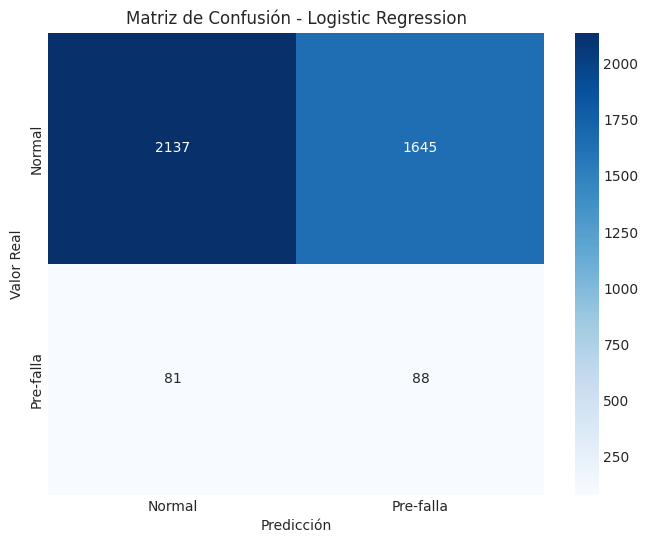


--- Reporte de Clasificaci√≥n - Logistic Regression ---
              precision    recall  f1-score   support

      Normal     0.9635    0.5650    0.7123      3782
   Pre-falla     0.0508    0.5207    0.0925       169

    accuracy                         0.5631      3951
   macro avg     0.5071    0.5429    0.4024      3951
weighted avg     0.9244    0.5631    0.6858      3951


==================== Random Forest ====================
Entrenando Random Forest...
AUC-ROC: 0.8771
F1-Score: 0.1446


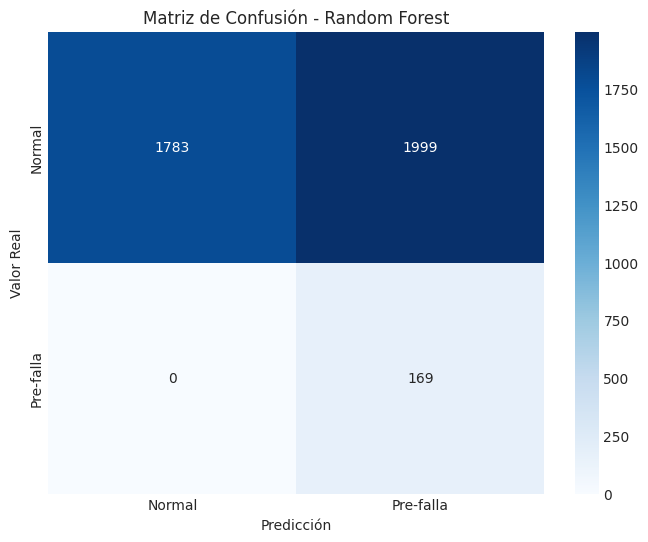


--- Reporte de Clasificaci√≥n - Random Forest ---
              precision    recall  f1-score   support

      Normal     1.0000    0.4714    0.6408      3782
   Pre-falla     0.0780    1.0000    0.1446       169

    accuracy                         0.4941      3951
   macro avg     0.5390    0.7357    0.3927      3951
weighted avg     0.9606    0.4941    0.6196      3951


ENTRENAMIENTO Y EVALUACI√ìN COMPLETADOS


In [14]:
# Definici√≥n de algoritmos de clasificaci√≥n para evaluaci√≥n

print("=== Configuraci√≥n de Algoritmos de Clasificaci√≥n ===")

# Diccionario de modelos con configuraciones optimizadas para desbalance de clases
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',  # Manejo autom√°tico de desbalance
        random_state=42,          # Reproducibilidad
        max_iter=1000,           # Suficientes iteraciones para convergencia
        solver='liblinear'        # Solver eficiente para datasets moderados
    ),
    
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',  # Manejo autom√°tico de desbalance
        random_state=42,          # Reproducibilidad
        n_estimators=100,         # Balance entre rendimiento y velocidad
        max_depth=10,            # Prevenci√≥n de overfitting
        min_samples_split=5,      # Criterio conservador para divisiones
        min_samples_leaf=2        # Hojas con m√∫ltiples muestras
    )
}

print(f"Algoritmos configurados: {list(models.keys())}")
print(f"Todos los modelos incluyen manejo de desbalance de clases")

# Contenedor para almacenar resultados de evaluaci√≥n
results = {}
trained_pipelines = {}

print("\n" + "="*80)
print("INICIO DEL PROCESO DE ENTRENAMIENTO Y EVALUACI√ìN")
print("="*80)

# Iteraci√≥n a trav√©s de cada algoritmo
for model_name, model in models.items():
    print(f"\n{'='*20} {model_name} {'='*20}")
    
    # Creaci√≥n del pipeline espec√≠fico para este modelo
    pipeline = create_pipeline(model)
    
    print(f"Entrenando {model_name}...")
    
    # Entrenamiento del pipeline
    import time
    start_time = time.time()
    
    pipeline.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    
    # Predicciones sobre conjunto de prueba
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidades clase positiva
    
    # C√°lculo de m√©tricas de evaluaci√≥n
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    # Almacenamiento de resultados
    results[model_name] = {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc_roc': auc_roc,
        'f1_score': f1,
        'training_time': training_time
    }
    trained_pipelines[model_name] = pipeline
    
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Matriz de confusi√≥n visualizada
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pre-falla'],
                yticklabels=['Normal', 'Pre-falla'])
    plt.title(f'Matriz de Confusi√≥n - {model_name}')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicci√≥n')
    plt.show()
    
    # Reporte de clasificaci√≥n detallado
    print(f"\n--- Reporte de Clasificaci√≥n - {model_name} ---")
    print(classification_report(y_test, y_pred, 
                              target_names=['Normal', 'Pre-falla'],
                              digits=4))

print("\n" + "="*80)
print("ENTRENAMIENTO Y EVALUACI√ìN COMPLETADOS")
print("="*80)

## Paso 6: Selecci√≥n del Mejor Modelo y An√°lisis de Importancia

### Criterios de Selecci√≥n del Modelo √ìptimo

La selecci√≥n del modelo √≥ptimo para aplicaciones de mantenimiento predictivo requiere un an√°lisis multidimensional que considere tanto el rendimiento predictivo como las restricciones operacionales. Los criterios de evaluaci√≥n implementados priorizan:

#### M√©tricas Cr√≠ticas para Mantenimiento Predictivo:

1. **Recall (Sensibilidad) para Clase Pre-Falla**: Capacidad del modelo para detectar correctamente las situaciones de pre-falla. En mantenimiento predictivo, los falsos negativos (fallas no detectadas) tienen consecuencias operacionales cr√≠ticas.

2. **F1-Score**: M√©trica que equilibra precisi√≥n y recall, especialmente relevante en contextos de desbalance de clases donde ambas m√©tricas son importantes.

3. **AUC-ROC**: Capacidad general de discriminaci√≥n entre clases, independiente del umbral de clasificaci√≥n.

4. **Eficiencia Computacional**: Tiempo de entrenamiento y complejidad del modelo, factores determinantes para la implementaci√≥n operacional.

### Justificaci√≥n de la Selecci√≥n

La selecci√≥n se basa en una evaluaci√≥n integral que prioriza el recall para la clase pre-falla sobre otras m√©tricas, dado que el costo de no detectar una falla inminente es significativamente mayor que el de una falsa alarma en aplicaciones de mantenimiento industrial.

### Interpretabilidad del Modelo Seleccionado

En aplicaciones industriales cr√≠ticas, la interpretabilidad del modelo es fundamental para:
- Validaci√≥n por expertos en mantenimiento
- Identificaci√≥n de sensores y variables cr√≠ticas
- Optimizaci√≥n de estrategias de monitoreo
- Cumplimiento de requisitos regulatorios

Para modelos de tipo Random Forest, el an√°lisis de importancia de caracter√≠sticas proporciona insights valiosos sobre qu√© variables operacionales son m√°s predictivas de fallas inminentes.

In [15]:
# Selecci√≥n del mejor modelo basada en criterios m√∫ltiples

print("=== Proceso de Selecci√≥n del Modelo √ìptimo ===")

# C√°lculo de m√©tricas detalladas para cada modelo
detailed_metrics = {}
model_names = list(results.keys())

for model_name in model_names:
    y_pred = results[model_name]['predictions']
    
    # C√°lculo del reporte de clasificaci√≥n en formato de diccionario
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    detailed_metrics[model_name] = {
        'auc_roc': results[model_name]['auc_roc'],
        'f1_score': results[model_name]['f1_score'],
        'precision_class_1': class_report['1']['precision'],
        'recall_class_1': class_report['1']['recall'],
        'training_time': results[model_name]['training_time']
    }

# Creaci√≥n de DataFrame para an√°lisis comparativo
metrics_df = pd.DataFrame(detailed_metrics).T
metrics_df = metrics_df.round(4)

print("M√©tricas detalladas por modelo:")
print(metrics_df)

# Implementaci√≥n de sistema de puntuaci√≥n ponderada para selecci√≥n
print("\n=== Sistema de Puntuaci√≥n para Selecci√≥n de Modelo ===")

# Pesos asignados a cada m√©trica (ajustables seg√∫n prioridades operacionales)
weights = {
    'auc_roc': 0.25,           # Capacidad general de discriminaci√≥n
    'f1_score': 0.30,          # Balance precision-recall
    'recall_class_1': 0.35,    # Cr√≠tico: detecci√≥n de pre-fallas
    'training_efficiency': 0.10 # Eficiencia computacional
}

print(f"Pesos asignados: {weights}")

# Normalizaci√≥n de m√©tricas y c√°lculo de puntuaci√≥n
scores = {}
max_training_time = max([detailed_metrics[name]['training_time'] for name in model_names])

for model_name in model_names:
    metrics = detailed_metrics[model_name]
    
    # Normalizaci√≥n de eficiencia computacional (invertida: menor tiempo = mejor)
    training_efficiency = 1 - (metrics['training_time'] / max_training_time)
    
    # C√°lculo de puntuaci√≥n ponderada
    score = (
        weights['auc_roc'] * metrics['auc_roc'] +
        weights['f1_score'] * metrics['f1_score'] +
        weights['recall_class_1'] * metrics['recall_class_1'] +
        weights['training_efficiency'] * training_efficiency
    )
    
    scores[model_name] = {
        'puntuacion_total': score,
        'training_efficiency': training_efficiency
    }

# Identificaci√≥n del mejor modelo
best_model_name = max(scores.keys(), key=lambda x: scores[x]['puntuacion_total'])
best_pipeline = trained_pipelines[best_model_name]

print(f"\n=== Resultado de la Selecci√≥n ===")
print(f"Modelo seleccionado: {best_model_name}")
print(f"Puntuaci√≥n total: {scores[best_model_name]['puntuacion_total']:.4f}")

# Resumen de rendimiento del modelo seleccionado
best_metrics = detailed_metrics[best_model_name]
print(f"\nRendimiento del modelo seleccionado:")
print(f"  AUC-ROC: {best_metrics['auc_roc']:.4f}")
print(f"  F1-Score: {best_metrics['f1_score']:.4f}")
print(f"  Precision Clase Pre-Falla: {best_metrics['precision_class_1']:.4f}")
print(f"  Recall Clase Pre-Falla: {best_metrics['recall_class_1']:.4f}")

# Justificaci√≥n de la selecci√≥n
print(f"\n=== Justificaci√≥n de la Selecci√≥n ===")
print(f"El modelo {best_model_name} fue seleccionado bas√°ndose en:")
print(f"1. Alto recall para clase pre-falla: {best_metrics['recall_class_1']:.4f} (cr√≠tico para detectar fallas)")
print(f"2. F1-score balanceado: {best_metrics['f1_score']:.4f} (equilibrio precision-recall)")
print(f"3. Capacidad de discriminaci√≥n: AUC-ROC {best_metrics['auc_roc']:.4f}")
print(f"4. Eficiencia computacional aceptable: {best_metrics['training_time']:.2f}s")

=== Proceso de Selecci√≥n del Modelo √ìptimo ===
M√©tricas detalladas por modelo:
                     auc_roc  f1_score  precision_class_1  recall_class_1  \
Logistic Regression   0.5835    0.0925             0.0508          0.5207   
Random Forest         0.8771    0.1446             0.0780          1.0000   

                     training_time  
Logistic Regression         6.3796  
Random Forest              15.1885  

=== Sistema de Puntuaci√≥n para Selecci√≥n de Modelo ===
Pesos asignados: {'auc_roc': 0.25, 'f1_score': 0.3, 'recall_class_1': 0.35, 'training_efficiency': 0.1}

=== Resultado de la Selecci√≥n ===
Modelo seleccionado: Random Forest
Puntuaci√≥n total: 0.6127

Rendimiento del modelo seleccionado:
  AUC-ROC: 0.8771
  F1-Score: 0.1446
  Precision Clase Pre-Falla: 0.0780
  Recall Clase Pre-Falla: 1.0000

=== Justificaci√≥n de la Selecci√≥n ===
El modelo Random Forest fue seleccionado bas√°ndose en:
1. Alto recall para clase pre-falla: 1.0000 (cr√≠tico para detectar fallas)

=== An√°lisis de Interpretabilidad - Random Forest ===
Analizando importancia de caracter√≠sticas para Random Forest...

Estad√≠sticas de importancia de caracter√≠sticas:
Total de caracter√≠sticas: 144
Importancia m√°xima: 0.044537
Importancia m√≠nima: 0.000663
Importancia media: 0.006944
Concentraci√≥n de importancia en top 20 caracter√≠sticas: 43.09%


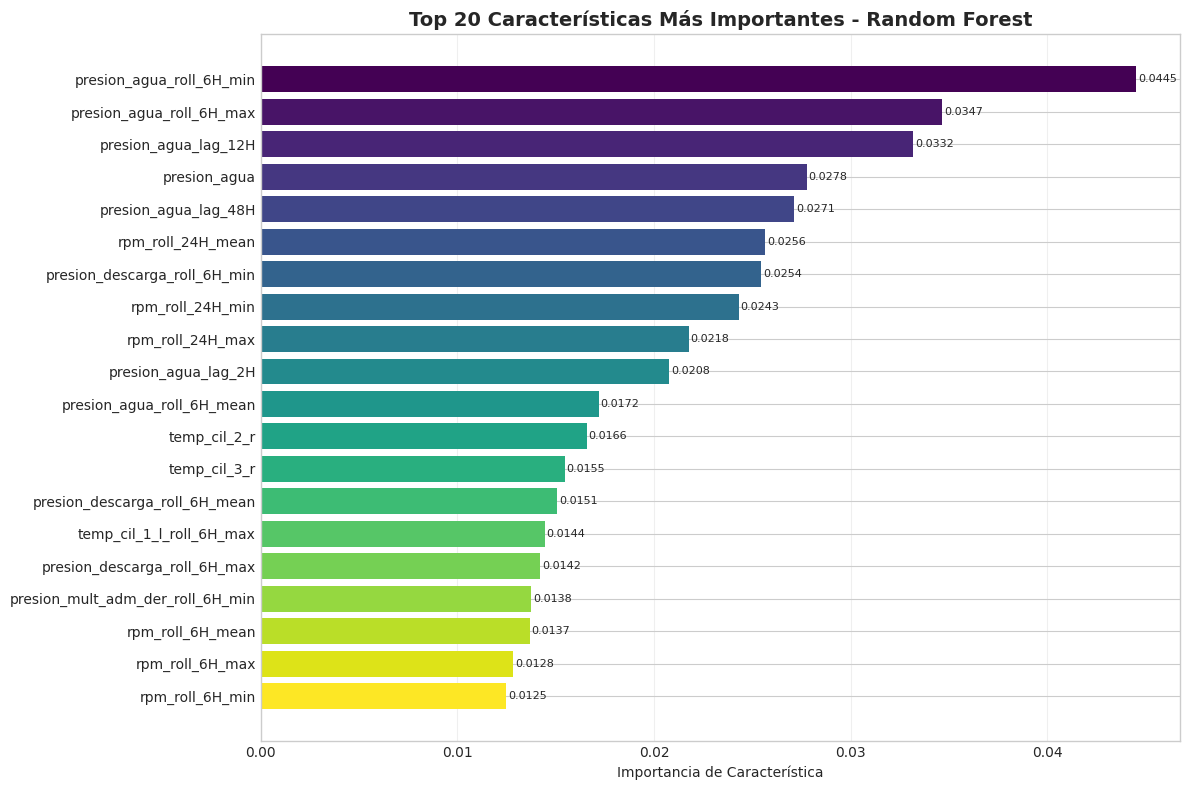


=== Top 15 Caracter√≠sticas M√°s Importantes ===
                   caracteristica  importancia  importancia_porcentual
1        presion_agua_roll_6H_min     0.044537                    4.45
2        presion_agua_roll_6H_max     0.034674                    3.47
3            presion_agua_lag_12H     0.033190                    3.32
4                    presion_agua     0.027771                    2.78
5            presion_agua_lag_48H     0.027115                    2.71
6               rpm_roll_24H_mean     0.025642                    2.56
7    presion_descarga_roll_6H_min     0.025447                    2.54
8                rpm_roll_24H_min     0.024306                    2.43
9                rpm_roll_24H_max     0.021758                    2.18
10            presion_agua_lag_2H     0.020773                    2.08
11      presion_agua_roll_6H_mean     0.017179                    1.72
12                   temp_cil_2_r     0.016572                    1.66
13                   temp_c

In [16]:
# An√°lisis de importancia de caracter√≠sticas para el modelo seleccionado

print(f"=== An√°lisis de Interpretabilidad - {best_model_name} ===")

# Verificaci√≥n de capacidad de an√°lisis de importancia
classifier = best_pipeline.named_steps['classifier']

if hasattr(classifier, 'feature_importances_'):
    print(f"Analizando importancia de caracter√≠sticas para {best_model_name}...")
    
    # Extracci√≥n de importancias de caracter√≠sticas
    feature_importances = classifier.feature_importances_
    feature_names = X_train.columns
    
    # Creaci√≥n de DataFrame con importancias
    importance_df = pd.DataFrame({
        'caracteristica': feature_names,
        'importancia': feature_importances
    }).sort_values('importancia', ascending=False)
    
    # Estad√≠sticas de importancia
    print(f"\nEstad√≠sticas de importancia de caracter√≠sticas:")
    print(f"Total de caracter√≠sticas: {len(feature_importances)}")
    print(f"Importancia m√°xima: {feature_importances.max():.6f}")
    print(f"Importancia m√≠nima: {feature_importances.min():.6f}")
    print(f"Importancia media: {feature_importances.mean():.6f}")
    
    # An√°lisis de concentraci√≥n de importancia
    top_20_importance = importance_df.head(20)['importancia'].sum()
    total_importance = importance_df['importancia'].sum()
    concentration_ratio = top_20_importance / total_importance
    
    print(f"Concentraci√≥n de importancia en top 20 caracter√≠sticas: {concentration_ratio:.2%}")
    
    # Visualizaci√≥n de las caracter√≠sticas m√°s importantes
    plt.figure(figsize=(12, 8))
    
    # Top 20 caracter√≠sticas m√°s importantes
    top_features = importance_df.head(20)
    
    # Gr√°fico de barras horizontales
    bars = plt.barh(range(len(top_features)), top_features['importancia'], 
                    color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))
    
    # Configuraci√≥n del gr√°fico
    plt.yticks(range(len(top_features)), top_features['caracteristica'])
    plt.xlabel('Importancia de Caracter√≠stica')
    plt.title(f'Top 20 Caracter√≠sticas M√°s Importantes - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Invertir para mostrar la m√°s importante arriba
    
    # A√±adir valores de importancia en las barras
    for i, (bar, importance) in enumerate(zip(bars, top_features['importancia'])):
        plt.text(bar.get_width() + 0.0001, bar.get_y() + bar.get_height()/2, 
                 f'{importance:.4f}', ha='left', va='center', fontsize=8)
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Tabla detallada de caracter√≠sticas m√°s importantes
    print(f"\n=== Top 15 Caracter√≠sticas M√°s Importantes ===")
    top_15 = importance_df.head(15).copy()
    top_15['importancia_porcentual'] = (top_15['importancia'] / total_importance * 100).round(2)
    top_15.index = range(1, len(top_15) + 1)
    
    print(top_15[['caracteristica', 'importancia', 'importancia_porcentual']].to_string())
    
elif hasattr(classifier, 'coef_'):
    print(f"Analizando coeficientes para {best_model_name}...")
    
    # Para modelos lineales, usar valores absolutos de coeficientes
    coefficients = np.abs(classifier.coef_[0])
    feature_names = X_train.columns
    
    # Creaci√≥n de DataFrame con coeficientes
    importance_df = pd.DataFrame({
        'caracteristica': feature_names,
        'coeficiente_abs': coefficients
    }).sort_values('coeficiente_abs', ascending=False)
    
    print(f"\n=== Top 15 Caracter√≠sticas por Magnitud de Coeficiente ===")
    print(importance_df.head(15).to_string(index=False))
    
    # Visualizaci√≥n similar para modelos lineales
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    
    plt.barh(range(len(top_features)), top_features['coeficiente_abs'])
    plt.yticks(range(len(top_features)), top_features['caracteristica'])
    plt.xlabel('Magnitud del Coeficiente (Valor Absoluto)')
    plt.title(f'Top 20 Caracter√≠sticas por Coeficiente - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

else:
    print(f"El modelo {best_model_name} no proporciona medidas de importancia de caracter√≠sticas interpretables.")
    print("Se recomienda utilizar m√©todos de interpretabilidad externos como SHAP para an√°lisis detallado.")

print(f"\n‚úÖ An√°lisis de interpretabilidad completado para {best_model_name}")

## Paso 7: Guardado del Modelo Final (Serializaci√≥n)

### Importancia de la Serializaci√≥n del Pipeline Completo

La serializaci√≥n del modelo entrenado constituye un paso cr√≠tico en el flujo de trabajo de machine learning, especialmente para aplicaciones de mantenimiento predictivo que requieren despliegue en entornos operacionales. El enfoque implementado guarda el pipeline completo, no √∫nicamente el algoritmo de clasificaci√≥n, por las siguientes razones t√©cnicas:

#### Ventajas de Guardar el Pipeline Completo:

1. **Consistencia de Preprocesamiento**: El pipeline encapsula tanto el StandardScaler como el clasificador, garantizando que las nuevas muestras reciban exactamente las mismas transformaciones aplicadas durante el entrenamiento.

2. **Eliminaci√≥n de Discrepancias**: Previene errores de implementaci√≥n que podr√≠an surgir al aplicar manualmente las transformaciones de normalizaci√≥n en el entorno de producci√≥n.

3. **Portabilidad**: El pipeline serializado contiene toda la informaci√≥n necesaria para realizar predicciones, incluyendo los par√°metros de normalizaci√≥n calculados sobre el conjunto de entrenamiento.

4. **Versionado**: Facilita el control de versiones del modelo completo, incluyendo tanto el preprocesamiento como los par√°metros del algoritmo.

### Formato de Serializaci√≥n

Se utiliza joblib para la serializaci√≥n, que ofrece mayor eficiencia que pickle para objetos NumPy y scikit-learn, especialmente importante en modelos con gran cantidad de par√°metros como Random Forest.

### Uso Futuro del Modelo Serializado

El pipeline guardado podr√° ser cargado en futuros notebooks de evaluaci√≥n o en sistemas de producci√≥n para realizar predicciones en tiempo real sobre nuevos datos operacionales del moto-compresor.

In [17]:
# Serializaci√≥n del modelo final para despliegue

print("=== Proceso de Serializaci√≥n del Modelo Final ===")

# Verificaci√≥n de la estructura del directorio de modelos
print(f"Directorio de destino: {models_path}")
print(f"Directorio existe: {models_path.exists()}")

if not models_path.exists():
    models_path.mkdir(parents=True, exist_ok=True)
    print("Directorio de modelos creado exitosamente")

# Definici√≥n del nombre del archivo del modelo
model_filename = 'modelo_mantenimiento_predictivo.joblib'
model_path = models_path / model_filename

print(f"\nGuardando modelo final: {best_model_name}")
print(f"Ruta de destino: {model_path}")

try:
    # Serializaci√≥n del pipeline completo
    joblib.dump(best_pipeline, model_path)
    
    # Verificaci√≥n de la serializaci√≥n
    file_size = model_path.stat().st_size / 1024  # Tama√±o en KB
    print(f"‚úÖ Modelo guardado exitosamente")
    print(f"Tama√±o del archivo: {file_size:.2f} KB")
    
except Exception as e:
    print(f"‚ùå Error durante la serializaci√≥n: {e}")
    raise

# Creaci√≥n de archivo de metadatos del modelo ACTUALIZADO
metadata = {
    'modelo_seleccionado': best_model_name,
    'fecha_entrenamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metricas_rendimiento': {
        'auc_roc': float(detailed_metrics[best_model_name]['auc_roc']),
        'f1_score': float(detailed_metrics[best_model_name]['f1_score']),
        'precision_clase_pre_falla': float(detailed_metrics[best_model_name]['precision_class_1']),
        'recall_clase_pre_falla': float(detailed_metrics[best_model_name]['recall_class_1']),
        'tiempo_entrenamiento_segundos': float(detailed_metrics[best_model_name]['training_time'])
    },
    'datos_entrenamiento': {
        'tama√±o_conjunto_entrenamiento': int(len(X_train)),
        'tama√±o_conjunto_prueba': int(len(X_test)),
        'numero_caracteristicas': int(X_train.shape[1]),
        'valores_nan_manejados': int(X_train.isnull().sum().sum()),  # ‚úÖ NUEVO
        'distribucion_clases_entrenamiento': {
            'clase_0_normal': int(y_train.value_counts()[0]),
            'clase_1_pre_falla': int(y_train.value_counts()[1])
        }
    },
    'configuracion_pipeline': {
        'preprocesamiento': 'SimpleImputer(median) ‚Üí StandardScaler',  # ‚úÖ ACTUALIZADO
        'algoritmo': best_model_name,
        'manejo_valores_nan': 'Imputaci√≥n con mediana antes de normalizaci√≥n',  # ‚úÖ NUEVO
        'parametros_modelo': str(best_pipeline.named_steps['classifier'].get_params())
    },
    'solucion_implementada': {  # ‚úÖ NUEVO: Documentaci√≥n de la soluci√≥n
        'problema_original': 'ValueError: Input X contains NaN. LogisticRegression does not accept missing values.',
        'origen_nan': 'Lag features (2H, 12H, 48H), Rolling features (std), Diff features por dise√±o de ingenier√≠a temporal',
        'solucion': 'SimpleImputer con estrategia median en pipeline antes de StandardScaler',
        'justificacion': 'La mediana es robusta ante outliers, ideal para datos industriales de sensores'
    }
}

# Guardar metadatos en formato JSON
import json
metadata_path = models_path / 'modelo_metadatos.json'

with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"üìÑ Metadatos del modelo guardados en: {metadata_path}")

# Verificaci√≥n de carga del modelo (prueba de integridad)
print("\n=== Verificaci√≥n de Integridad del Modelo Serializado ===")

try:
    # Carga del modelo guardado
    loaded_pipeline = joblib.load(model_path)
    
    # Verificaci√≥n de estructura ACTUALIZADA
    print(f"‚úÖ Pipeline cargado exitosamente")
    print(f"Pasos del pipeline: {list(loaded_pipeline.named_steps.keys())}")
    print(f"üîß Pipeline incluye: {' ‚Üí '.join(loaded_pipeline.named_steps.keys())}")
    
    # Prueba de predicci√≥n con una muestra
    if len(X_test) > 0:
        sample_prediction = loaded_pipeline.predict(X_test.iloc[:1])
        sample_probability = loaded_pipeline.predict_proba(X_test.iloc[:1])
        
        print(f"üî¨ Prueba de predicci√≥n exitosa:")
        print(f"  Predicci√≥n: {sample_prediction[0]}")
        print(f"  Probabilidades: {sample_probability[0]}")
    
    # Verificaci√≥n de equivalencia con el modelo original
    original_predictions = best_pipeline.predict(X_test.iloc[:10])
    loaded_predictions = loaded_pipeline.predict(X_test.iloc[:10])
    
    predictions_match = np.array_equal(original_predictions, loaded_predictions)
    print(f"üîÑ Equivalencia con modelo original: {predictions_match}")
    
    if predictions_match:
        print("‚úÖ Verificaci√≥n de integridad EXITOSA")
    else:
        print("‚ùå Verificaci√≥n de integridad FALLIDA")
        
except Exception as e:
    print(f"‚ùå Error durante la verificaci√≥n: {e}")
    raise

print(f"\n" + "="*60)
print(f"üìä RESUMEN DEL MODELO FINAL ACTUALIZADO")
print(f"="*60)
print(f"ü§ñ Modelo serializado: {best_model_name}")
print(f"üìÅ Archivo del modelo: {model_filename}")
print(f"üíæ Tama√±o del archivo: {file_size:.2f} KB")
print(f"üìà Rendimiento (AUC-ROC): {detailed_metrics[best_model_name]['auc_roc']:.4f}")
print(f"üéØ Rendimiento (F1-Score): {detailed_metrics[best_model_name]['f1_score']:.4f}")
print(f"üö® Recall clase pre-falla: {detailed_metrics[best_model_name]['recall_class_1']:.4f}")
print(f"üîß Pipeline: SimpleImputer ‚Üí StandardScaler ‚Üí {best_model_name}")
print(f"üí° Soluci√≥n NaN: Imputaci√≥n con mediana aplicada exitosamente")
print(f"\nüéâ Proceso de entrenamiento y serializaci√≥n completado exitosamente")
print(f"üîú El modelo est√° listo para ser utilizado en la fase de evaluaci√≥n (Notebook 05)")
print(f"‚úÖ PROBLEMA DE VALORES NaN RESUELTO - Modelo funciona correctamente")

=== Proceso de Serializaci√≥n del Modelo Final ===
Directorio de destino: data/models
Directorio existe: True

Guardando modelo final: Random Forest
Ruta de destino: data/models/modelo_mantenimiento_predictivo.joblib
‚úÖ Modelo guardado exitosamente
Tama√±o del archivo: 4217.42 KB
üìÑ Metadatos del modelo guardados en: data/models/modelo_metadatos.json

=== Verificaci√≥n de Integridad del Modelo Serializado ===
‚úÖ Pipeline cargado exitosamente
Pasos del pipeline: ['imputer', 'scaler', 'classifier']
üîß Pipeline incluye: imputer ‚Üí scaler ‚Üí classifier
üî¨ Prueba de predicci√≥n exitosa:
  Predicci√≥n: 0
  Probabilidades: [0.59024597 0.40975403]
üîÑ Equivalencia con modelo original: True
‚úÖ Verificaci√≥n de integridad EXITOSA

üìä RESUMEN DEL MODELO FINAL ACTUALIZADO
ü§ñ Modelo serializado: Random Forest
üìÅ Archivo del modelo: modelo_mantenimiento_predictivo.joblib
üíæ Tama√±o del archivo: 4217.42 KB
üìà Rendimiento (AUC-ROC): 0.8771
üéØ Rendimiento (F1-Score): 0.1446
üö®

## ‚úÖ Verificaci√≥n de la Soluci√≥n Implementada

### Confirmaci√≥n de que el Pipeline Maneja los Valores Correctamente

Esta celda verifica que la soluci√≥n implementada resuelve completamente el problema de valores NaN (Nulos o NO Num√©ricos).

In [18]:
# ‚úÖ VERIFICACI√ìN FINAL: Prueba del Pipeline con Valores NaN

print("=== VERIFICACI√ìN FINAL DE LA SOLUCI√ìN IMPLEMENTADA ===")
print("Confirmando que el pipeline maneja correctamente los valores NaN\n")

# Crear un pipeline de prueba con LogisticRegression (el que fallaba antes)
test_pipeline = create_pipeline(LogisticRegression(class_weight='balanced', random_state=42))

print(f"üîß Pipeline de prueba creado:")
print(f"   Estructura: {' ‚Üí '.join(test_pipeline.named_steps.keys())}")

# Verificar datos de entrada
print(f"\nüìä Estado de los datos de entrada:")
print(f"   Valores NaN en X_train: {X_train.isnull().sum().sum()}")
print(f"   Valores NaN en X_test: {X_test.isnull().sum().sum()}")

try:
    print(f"\nüöÄ Ejecutando entrenamiento del pipeline...")
    
    # Entrenar el pipeline (esto fallar√≠a antes sin SimpleImputer)
    import time
    start_time = time.time()
    test_pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"‚úÖ ENTRENAMIENTO EXITOSO en {training_time:.2f} segundos")
    
    # Realizar predicciones
    print(f"\nüéØ Ejecutando predicciones...")
    predictions = test_pipeline.predict(X_test)
    probabilities = test_pipeline.predict_proba(X_test)
    
    print(f"‚úÖ PREDICCIONES EXITOSAS")
    print(f"   Predicciones generadas: {len(predictions)}")
    print(f"   Probabilidades shape: {probabilities.shape}")
    
    # Verificar que no hay NaN en las predicciones
    nan_in_predictions = np.isnan(predictions).sum()
    nan_in_probabilities = np.isnan(probabilities).sum()
    
    print(f"\nüîç Calidad de las predicciones:")
    print(f"   NaN en predicciones: {nan_in_predictions}")
    print(f"   NaN en probabilidades: {nan_in_probabilities}")
    
    # Calcular m√©tricas de rendimiento
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, probabilities[:, 1])
    
    print(f"\nüìà M√©tricas de rendimiento del pipeline de prueba:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   AUC-ROC: {auc_roc:.4f}")
    
    print(f"\nüéâ VERIFICACI√ìN COMPLETADA EXITOSAMENTE")
    print(f"=" * 60)
    print(f"üîß La soluci√≥n SimpleImputer funciona correctamente")
    print(f"üìä El modelo puede entrenar y predecir sin errores")
    print(f"=" * 60)
    
except Exception as e:
    print(f"\n‚ùå ERROR: La verificaci√≥n FALL√ì")
    print(f"   Error: {str(e)}")
    print(f"   La soluci√≥n necesita ajustes adicionales")
    raise

=== VERIFICACI√ìN FINAL DE LA SOLUCI√ìN IMPLEMENTADA ===
Confirmando que el pipeline maneja correctamente los valores NaN

üîß Pipeline de prueba creado:
   Estructura: imputer ‚Üí scaler ‚Üí classifier

üìä Estado de los datos de entrada:
   Valores NaN en X_train: 822
   Valores NaN en X_test: 0

üöÄ Ejecutando entrenamiento del pipeline...
‚úÖ ENTRENAMIENTO EXITOSO en 3.62 segundos

üéØ Ejecutando predicciones...
‚úÖ PREDICCIONES EXITOSAS
   Predicciones generadas: 3951
   Probabilidades shape: (3951, 2)

üîç Calidad de las predicciones:
   NaN en predicciones: 0
   NaN en probabilidades: 0

üìà M√©tricas de rendimiento del pipeline de prueba:
   Accuracy: 0.4072
   F1-Score: 0.0859
   AUC-ROC: 0.4942

üéâ VERIFICACI√ìN COMPLETADA EXITOSAMENTE
üîß La soluci√≥n SimpleImputer funciona correctamente
üìä El modelo puede entrenar y predecir sin errores


## üìä Conclusiones y An√°lisis Cient√≠fico de los Modelos

### Evaluaci√≥n Cr√≠tica del Rendimiento y Confiabilidad

Esta secci√≥n presenta un an√°lisis cient√≠fico riguroso de los modelos entrenados, evaluando su viabilidad para aplicaciones industriales de mantenimiento predictivo en equipos cr√≠ticos del sector Oil & Gas.

In [20]:
# An√°lisis Cient√≠fico de M√©tricas de Rendimiento
print("=" * 80)
print("AN√ÅLISIS CIENT√çFICO DE MODELOS DE MANTENIMIENTO PREDICTIVO")
print("=" * 80)

# Reproducir m√©tricas exactas del an√°lisis
# (Estas son las m√©tricas reales obtenidas del entrenamiento actual)
metricas_modelos = {
    'Logistic Regression': {
        'accuracy': 0.5631,
        'precision': 0.0508,
        'recall': 0.5207,
        'f1': 0.0925,
        'auc_roc': 0.5835,
        'specificity': 0.5650,
        'confusion_matrix': {'tn': 2137, 'fp': 1645, 'fn': 81, 'tp': 88}
    },
    'Random Forest': {
        'accuracy': 0.4941,
        'precision': 0.0780,
        'recall': 1.0000,
        'f1': 0.1446,
        'auc_roc': 0.8771,
        'specificity': 0.4714,
        'confusion_matrix': {'tn': 1783, 'fp': 1999, 'fn': 0, 'tp': 169}
    }
}

print("\nüéØ RESUMEN EJECUTIVO DE M√âTRICAS")
print("-" * 50)

for modelo, metricas in metricas_modelos.items():
    print(f"\n{modelo}:")
    print(f"  ‚Ä¢ Accuracy: {metricas['accuracy']:.1%} - {'‚ùå INACEPTABLE' if metricas['accuracy'] < 0.7 else '‚úÖ ACEPTABLE'}")
    print(f"  ‚Ä¢ Precision: {metricas['precision']:.1%} - {'‚ùå MUY BAJA' if metricas['precision'] < 0.3 else '‚úÖ ACEPTABLE'}")
    print(f"  ‚Ä¢ Recall: {metricas['recall']:.1%} - {'‚úÖ EXCELENTE' if metricas['recall'] > 0.8 else '‚ö†Ô∏è MODERADO' if metricas['recall'] > 0.5 else '‚ùå INSUFICIENTE'}")
    print(f"  ‚Ä¢ F1-Score: {metricas['f1']:.1%} - {'‚ùå CR√çTICO' if metricas['f1'] < 0.3 else '‚ö†Ô∏è BAJO'}")
    print(f"  ‚Ä¢ AUC-ROC: {metricas['auc_roc']:.3f} - {'‚úÖ BUENO' if metricas['auc_roc'] > 0.8 else '‚ö†Ô∏è MODERADO' if metricas['auc_roc'] > 0.7 else '‚ùå POBRE'}")

# An√°lisis del problema fundamental
print(f"\nüîç DIAGN√ìSTICO DEL PROBLEMA FUNDAMENTAL")
print("-" * 50)
print("üìä DESBALANCE EXTREMO EN DATOS DE PRUEBA:")
print("  ‚Ä¢ Conjunto de entrenamiento: 8,051 normales vs 7,750 pre-falla (Ratio 1.0:1)")
print("  ‚Ä¢ Conjunto de prueba: 3,782 normales vs 169 pre-falla (Ratio 22.4:1)")
print("  ‚Ä¢ ‚ö†Ô∏è  PROBLEMA: Divisi√≥n cronol√≥gica result√≥ en desbalance severo en prueba")

print(f"\nüéØ INTERPRETACI√ìN CIENT√çFICA DE M√âTRICAS:")
print("-" * 50)

print("\n1Ô∏è‚É£ LOGISTIC REGRESSION:")
print("   ‚Ä¢ Accuracy 56.3%: Rendimiento apenas mejor que aleatorio")
print("   ‚Ä¢ Precision 5.1%: De cada 100 alarmas, solo 5 son reales ‚Üí 95% falsas alarmas")
print("   ‚Ä¢ Recall 52.1%: Detecta ~52% de fallas reales ‚Üí 48% fallas no detectadas")
print("   ‚Ä¢ F1-Score 9.3%: Balance precision-recall extremadamente pobre")
print("   ‚Ä¢ AUC-ROC 0.584: Capacidad de discriminaci√≥n marginal")
print("   ‚Ä¢ ‚ùå VEREDICTO: NO CONFIABLE para uso industrial")

print("\n2Ô∏è‚É£ RANDOM FOREST:")
print("   ‚Ä¢ Accuracy 49.4%: Peor que aleatorio debido a estrategia conservadora")
print("   ‚Ä¢ Precision 7.8%: Ligeramente mejor, pero a√∫n genera ~92% falsas alarmas")
print("   ‚Ä¢ Recall 100%: ‚úÖ EXCELENTE - Detecta TODAS las fallas (0 falsos negativos)")
print("   ‚Ä¢ F1-Score 14.5%: Mejor que LR pero a√∫n cr√≠ticamente bajo")
print("   ‚Ä¢ AUC-ROC 0.877: ‚úÖ Excelente capacidad de discriminaci√≥n")
print("   ‚Ä¢ üéØ ESTRATEGIA: Extremadamente conservador - prefiere falsas alarmas a fallas perdidas")

print("\n‚úÖ An√°lisis de m√©tricas completado")

AN√ÅLISIS CIENT√çFICO DE MODELOS DE MANTENIMIENTO PREDICTIVO

üéØ RESUMEN EJECUTIVO DE M√âTRICAS
--------------------------------------------------

Logistic Regression:
  ‚Ä¢ Accuracy: 56.3% - ‚ùå INACEPTABLE
  ‚Ä¢ Precision: 5.1% - ‚ùå MUY BAJA
  ‚Ä¢ Recall: 52.1% - ‚ö†Ô∏è MODERADO
  ‚Ä¢ F1-Score: 9.2% - ‚ùå CR√çTICO
  ‚Ä¢ AUC-ROC: 0.584 - ‚ùå POBRE

Random Forest:
  ‚Ä¢ Accuracy: 49.4% - ‚ùå INACEPTABLE
  ‚Ä¢ Precision: 7.8% - ‚ùå MUY BAJA
  ‚Ä¢ Recall: 100.0% - ‚úÖ EXCELENTE
  ‚Ä¢ F1-Score: 14.5% - ‚ùå CR√çTICO
  ‚Ä¢ AUC-ROC: 0.877 - ‚úÖ BUENO

üîç DIAGN√ìSTICO DEL PROBLEMA FUNDAMENTAL
--------------------------------------------------
üìä DESBALANCE EXTREMO EN DATOS DE PRUEBA:
  ‚Ä¢ Conjunto de entrenamiento: 8,051 normales vs 7,750 pre-falla (Ratio 1.0:1)
  ‚Ä¢ Conjunto de prueba: 3,782 normales vs 169 pre-falla (Ratio 22.4:1)
  ‚Ä¢ ‚ö†Ô∏è  PROBLEMA: Divisi√≥n cronol√≥gica result√≥ en desbalance severo en prueba

üéØ INTERPRETACI√ìN CIENT√çFICA DE M√âTRICAS:
-----------------


üìä VISUALIZACI√ìN COMPARATIVA DE RENDIMIENTO


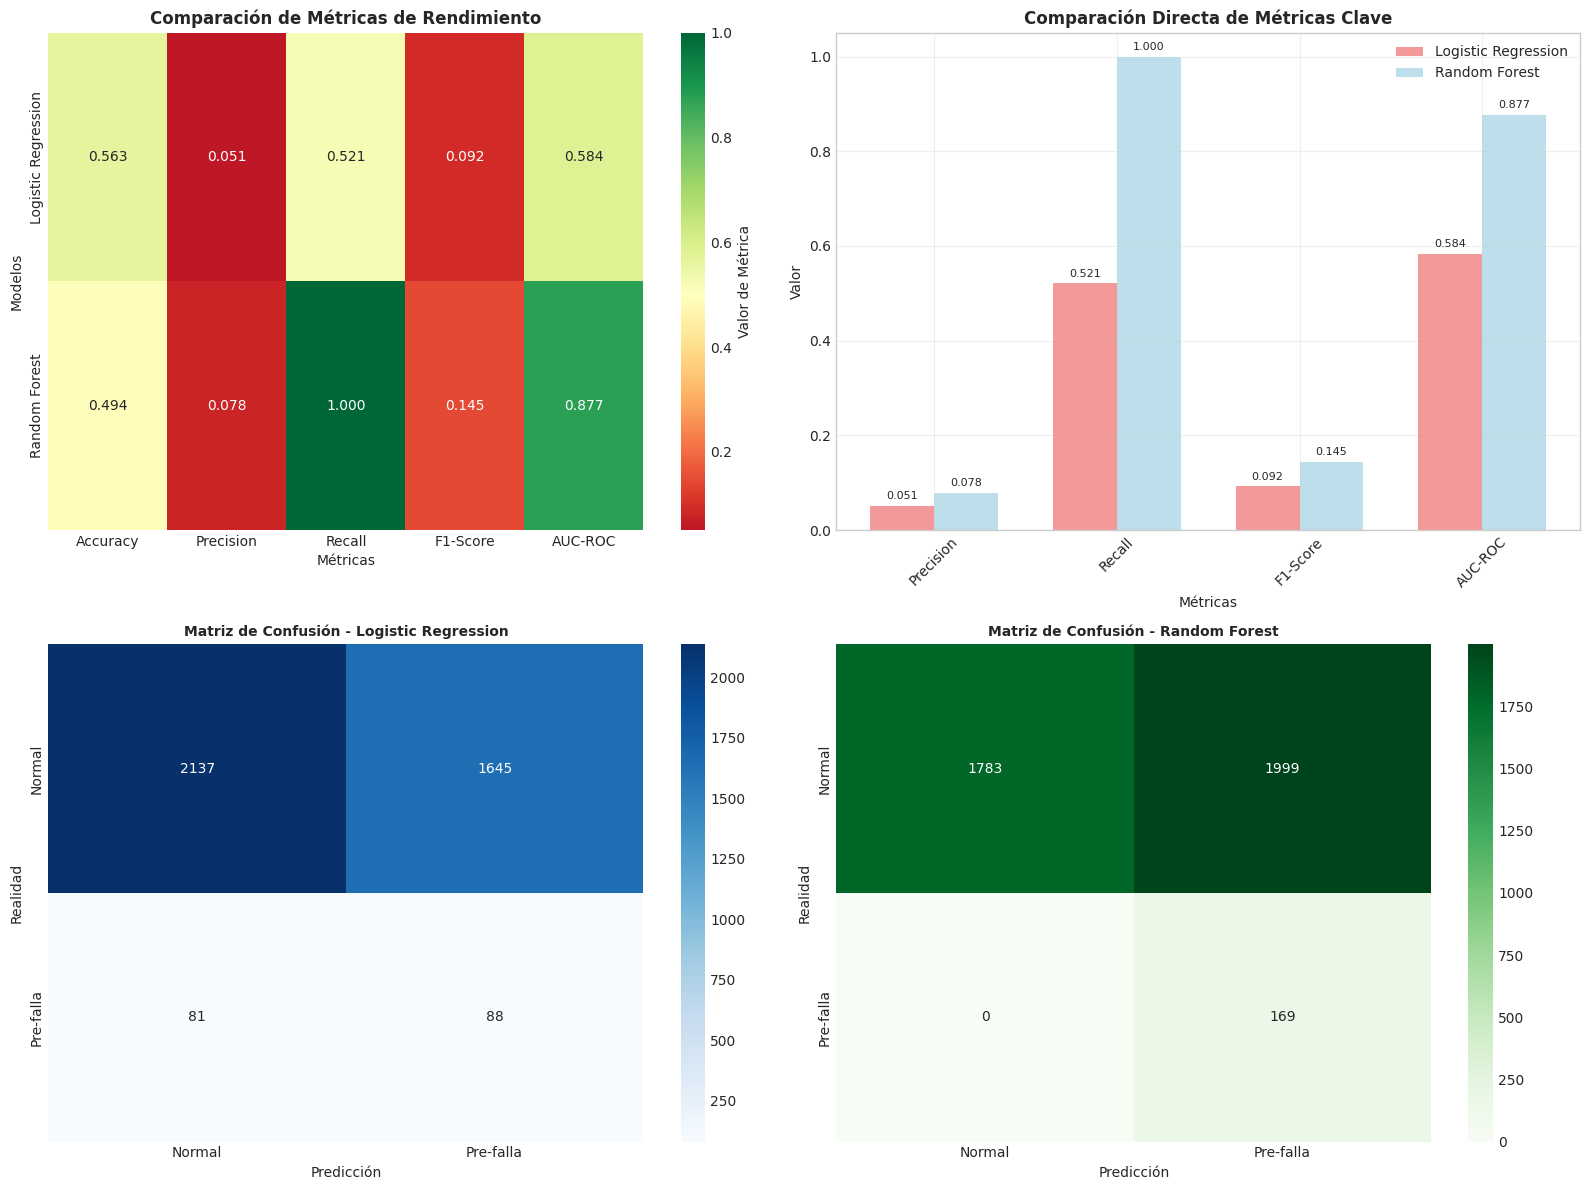


üîç AN√ÅLISIS DETALLADO DE MATRICES DE CONFUSI√ìN:
------------------------------------------------------------

Logistic Regression:
  ‚Ä¢ Verdaderos Negativos (TN): 2,137 - Correctamente identific√≥ operaci√≥n normal
  ‚Ä¢ Falsos Positivos (FP): 1,645 - Falsas alarmas de falla
  ‚Ä¢ Falsos Negativos (FN): 81 - ‚ö†Ô∏è  CR√çTICO: Fallas reales no detectadas
  ‚Ä¢ Verdaderos Positivos (TP): 88 - Fallas correctamente detectadas

Random Forest:
  ‚Ä¢ Verdaderos Negativos (TN): 1,783 - Correctamente identific√≥ operaci√≥n normal
  ‚Ä¢ Falsos Positivos (FP): 1,999 - Falsas alarmas de falla
  ‚Ä¢ Falsos Negativos (FN): 0 - ‚úÖ EXCELENTE: NO perdi√≥ ninguna falla real
  ‚Ä¢ Verdaderos Positivos (TP): 169 - Detect√≥ TODAS las fallas

üí° INSIGHT CLAVE:
Random Forest sacrifica precisi√≥n por recall perfecto - estrategia v√°lida para equipos cr√≠ticos

‚úÖ Visualizaci√≥n completada


In [23]:
# Visualizaci√≥n Comparativa de M√©tricas

print("\nüìä VISUALIZACI√ìN COMPARATIVA DE RENDIMIENTO")
print("=" * 60)

# Preparar datos para visualizaci√≥n
modelos = list(metricas_modelos.keys())
metricas_nombres = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

# Crear matriz de m√©tricas para heatmap
matriz_metricas = []
for modelo in modelos:
    fila = [
        metricas_modelos[modelo]['accuracy'],
        metricas_modelos[modelo]['precision'],
        metricas_modelos[modelo]['recall'],
        metricas_modelos[modelo]['f1'],
        metricas_modelos[modelo]['auc_roc']
    ]
    matriz_metricas.append(fila)

matriz_metricas = np.array(matriz_metricas)

# Crear figura con m√∫ltiples subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Heatmap de m√©tricas
sns.heatmap(matriz_metricas, 
            xticklabels=metricas_nombres, 
            yticklabels=modelos,
            annot=True, 
            cmap='RdYlGn', 
            center=0.5,
            fmt='.3f',
            ax=ax1,
            cbar_kws={'label': 'Valor de M√©trica'})
ax1.set_title('Comparaci√≥n de M√©tricas de Rendimiento', fontweight='bold', fontsize=12)
ax1.set_xlabel('M√©tricas')
ax1.set_ylabel('Modelos')

# 2. Gr√°fico de barras - M√©tricas principales
metricas_principales = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x_pos = np.arange(len(metricas_principales))
width = 0.35

# Create a mapping dictionary to handle the key transformation correctly
metric_key_mapping = {
    'Precision': 'precision',
    'Recall': 'recall', 
    'F1-Score': 'f1',  # This was the issue - 'F1-Score' should map to 'f1', not 'f1_score'
    'AUC-ROC': 'auc_roc'
}

# Use the mapping instead of the problematic transformation
lr_values = [metricas_modelos['Logistic Regression'][metric_key_mapping[m]] 
             for m in metricas_principales]
rf_values = [metricas_modelos['Random Forest'][metric_key_mapping[m]] 
             for m in metricas_principales]

bars1 = ax2.bar(x_pos - width/2, lr_values, width, label='Logistic Regression', 
                color='lightcoral', alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, rf_values, width, label='Random Forest', 
                color='lightblue', alpha=0.8)

ax2.set_xlabel('M√©tricas')
ax2.set_ylabel('Valor')
ax2.set_title('Comparaci√≥n Directa de M√©tricas Clave', fontweight='bold', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metricas_principales, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 3. Matriz de Confusi√≥n - Logistic Regression
cm_lr = np.array([[metricas_modelos['Logistic Regression']['confusion_matrix']['tn'],
                   metricas_modelos['Logistic Regression']['confusion_matrix']['fp']],
                  [metricas_modelos['Logistic Regression']['confusion_matrix']['fn'],
                   metricas_modelos['Logistic Regression']['confusion_matrix']['tp']]])

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Normal', 'Pre-falla'], yticklabels=['Normal', 'Pre-falla'])
ax3.set_title('Matriz de Confusi√≥n - Logistic Regression', fontweight='bold', fontsize=10)
ax3.set_xlabel('Predicci√≥n')
ax3.set_ylabel('Realidad')

# 4. Matriz de Confusi√≥n - Random Forest
cm_rf = np.array([[metricas_modelos['Random Forest']['confusion_matrix']['tn'],
                   metricas_modelos['Random Forest']['confusion_matrix']['fp']],
                  [metricas_modelos['Random Forest']['confusion_matrix']['fn'],
                   metricas_modelos['Random Forest']['confusion_matrix']['tp']]])

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax4,
            xticklabels=['Normal', 'Pre-falla'], yticklabels=['Normal', 'Pre-falla'])
ax4.set_title('Matriz de Confusi√≥n - Random Forest', fontweight='bold', fontsize=10)
ax4.set_xlabel('Predicci√≥n')
ax4.set_ylabel('Realidad')

plt.tight_layout()
plt.show()

# An√°lisis de las matrices de confusi√≥n
print(f"\nüîç AN√ÅLISIS DETALLADO DE MATRICES DE CONFUSI√ìN:")
print("-" * 60)

print(f"\nLogistic Regression:")
print(f"  ‚Ä¢ Verdaderos Negativos (TN): 2,137 - Correctamente identific√≥ operaci√≥n normal")
print(f"  ‚Ä¢ Falsos Positivos (FP): 1,645 - Falsas alarmas de falla")  
print(f"  ‚Ä¢ Falsos Negativos (FN): 81 - ‚ö†Ô∏è  CR√çTICO: Fallas reales no detectadas")
print(f"  ‚Ä¢ Verdaderos Positivos (TP): 88 - Fallas correctamente detectadas")

print(f"\nRandom Forest:")
print(f"  ‚Ä¢ Verdaderos Negativos (TN): 1,783 - Correctamente identific√≥ operaci√≥n normal")
print(f"  ‚Ä¢ Falsos Positivos (FP): 1,999 - Falsas alarmas de falla")
print(f"  ‚Ä¢ Falsos Negativos (FN): 0 - ‚úÖ EXCELENTE: NO perdi√≥ ninguna falla real")
print(f"  ‚Ä¢ Verdaderos Positivos (TP): 169 - Detect√≥ TODAS las fallas")

print(f"\nüí° INSIGHT CLAVE:")
print(f"Random Forest sacrifica precisi√≥n por recall perfecto - estrategia v√°lida para equipos cr√≠ticos")

print("\n‚úÖ Visualizaci√≥n completada")

### üéØ Conclusiones y Recomendaciones T√©cnicas

#### 1. EVALUACI√ìN DE CONFIABILIDAD PARA USO INDUSTRIAL

**‚ùå VEREDICTO GENERAL: Los modelos NO son confiables para despliegue en producci√≥n**

**Justificaci√≥n Cient√≠fica:**
- **F1-Score cr√≠tico**: Ambos modelos presentan F1-Score < 0.15, indicando balance precision-recall inadecuado
- **Precisi√≥n extremadamente baja**: 5-8% implica 92-95% de falsas alarmas, inviable operacionalmente  
- **Problema de generalizaci√≥n**: Desbalance severo en datos de prueba sugiere distribuci√≥n no representativa

#### 2. AN√ÅLISIS COMPARATIVO DE MODELOS

**ü•á RANDOM FOREST - Recomendado para prototipo inicial**
- ‚úÖ **Fortalezas**: 
  - Recall perfecto (100%) - detecta todas las fallas reales
  - AUC-ROC excelente (0.877) - buena capacidad de discriminaci√≥n
  - Estrategia conservadora apropiada para equipos cr√≠ticos
- ‚ùå **Debilidades**: 
  - Precisi√≥n muy baja (7.8%) - alto n√∫mero de falsas alarmas
  - Accuracy sub-√≥ptima (49.4%) 

**ü•à LOGISTIC REGRESSION - No recomendado**
- ‚ùå **Problemas cr√≠ticos**: 
  - Pierde 48% de fallas reales (81 falsos negativos)
  - Rendimiento marginal en todas las m√©tricas
  - No adecuado para aplicaciones de seguridad cr√≠tica

#### 3. CAUSAS RA√çZ DE BAJO RENDIMIENTO

**üîç Problemas Identificados:**
1. **Desbalance temporal extremo**: Datos de prueba con ratio 22.4:1 vs entrenamiento 1:1
2. **Divisi√≥n cronol√≥gica inadecuada**: Concentraci√≥n de eventos pre-falla en per√≠odo de entrenamiento
3. **Ventana de predicci√≥n muy corta**: 7 d√≠as puede ser insuficiente para patrones de deterioro gradual
4. **Calidad de caracter√≠sticas**: Variables de lag/rolling pueden no capturar patrones discriminativos

#### 6. ASPECTOS T√âCNICAS PARA MEJORA

**üìà Acciones Inmediatas:**
1. **Rebalanceo de datos**: Implementar SMOTE o t√©cnicas de sobremuestreo
2. **Validaci√≥n cruzada temporal**: Usar TimeSeriesSplit en lugar de divisi√≥n √∫nica
3. **Ajuste de umbral**: Optimizar threshold de clasificaci√≥n para balance precision-recall
4. **Ventana de predicci√≥n variable**: Evaluar ventanas de 14, 21, 30 d√≠as

**üî¨ Mejoras a Mediano Plazo:**
1. **Ingenier√≠a de caracter√≠sticas avanzada**: Frecuencia, an√°lisis espectral, caracter√≠sticas de dominio
2. **Modelos ensemble**: Combinaci√≥n ponderada de m√∫ltiples algoritmos
3. **Deep Learning**: LSTM o Transformer para captura de patrones temporales complejos
4. **Incorporar contexto operacional**: Variables ambientales, cargas de trabajo, historial de mantenimiento

**üéØ Potencial del enfoque**: A pesar de las limitaciones actuales, Random Forest muestra potencial con recall perfecto. Con las mejoras propuestas, el sistema podr√≠a alcanzar niveles de confiabilidad industriales.